# Performance analysis
In this notebook we analyzes the performance of the graph network in clustering and classifying the jets

In [124]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
import os
os.environ['DGLBACKEND'] = 'pytorch'
import dgl

from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dgl.nn import NNConv, EdgeConv
from dgl.nn.pytorch import Sequential as dglSequential
from dgl.dataloading import GraphDataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

from tsne_torch import TorchTSNE as TSNE
from kmeans_pytorch import kmeans, kmeans_predict
from sklearn.cluster import KMeans

## Define model and load it

In [2]:
class GraphDataset(Dataset):
    def __init__(self, data_path, n_files=None, lbl_to_load=None, transform=None):

        self.fnames    = [fname for fname in os.listdir(data_path) if fname.endswith('.dgl')]
        self.data_path = data_path

        if n_files:
            self.fnames = self.fnames[n_files]

        self.transform = transform     
        self.lbl_2_load = lbl_to_load

        self.load_graphs()


    def load_graphs(self):
        self.graphs = []

        for fname in tqdm(self.fnames, 'Reading files'):
            graphs, _ = dgl.load_graphs(os.path.join(self.data_path, fname))
            if self.lbl_2_load:
                self.graphs.extend([graph for graph in graphs if graph.ndata['labels'][0].nonzero().squeeze() in self.lbl_2_load])
            else:
                self.graphs.extend(graphs)


    def __len__(self):

        return len(self.graphs)
    

    def __getitem__(self, idx):

        x = self.graphs[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, latent_space_dim, ch=[256,128,64,32]):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(3, ch[0]),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(ch[0],ch[1]),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(ch[1],ch[2]),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(ch[2], ch[3]),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(ch[3], 7*128),
            nn.Sigmoid()
            )
        
        self.conv = dglSequential(
            NNConv(
                in_feats  = 7,  # number of node features
                out_feats = 128, # output number of node features
                edge_func = self.mlp),
            EdgeConv(128, 64, batch_norm=True),
            EdgeConv(64, 32, batch_norm=True),
            EdgeConv(32, latent_space_dim, batch_norm=True)
        )

    def forward(self, graph, n_feat=None):

        x = self.conv(graph, n_feat if n_feat else graph.ndata['f'], graph.edata['d'])
        return x
    

class Decoder(nn.Module):
    
    def __init__(self, latent_space_dim, n_feat=7):
        super().__init__()

        self.shared_path = dglSequential(
            EdgeConv(latent_space_dim, 32, batch_norm=True),
            EdgeConv(32, 64, batch_norm=True),
            EdgeConv(64, 128, batch_norm=True)
        )
        
        self.node_reconstruct = EdgeConv(128, n_feat)    # output are the reconstructed node features

        self.edge_reconstruct1 = dglSequential(
            EdgeConv(128, 32, batch_norm=True),
            EdgeConv(32,16, batch_norm=True),
            EdgeConv(16,8, batch_norm=True)
        )

        self.edge_reconstruct2 = dglSequential(
            EdgeConv(128, 32, batch_norm=True),
            EdgeConv(32,16, batch_norm=True),
            EdgeConv(16,8, batch_norm=True)
        )

        self.edge_reconstruct3 = dglSequential(
            EdgeConv(128, 32, batch_norm=True),
            EdgeConv(32,16, batch_norm=True),
            EdgeConv(16,8, batch_norm=True)
        )

    def forward(self, graph, n_feat=None):
        
        if n_feat is None:
            n_feat = graph.ndata['l']

        # shared path
        shared = self.shared_path(graph, n_feat)

        # node reconstruction
        n = self.node_reconstruct(graph, shared)
        
        # edges reconstruction
        e1 = self.edge_reconstruct1(graph, shared)
        e2 = self.edge_reconstruct2(graph, shared)
        e3 = self.edge_reconstruct3(graph, shared)

        # inner product o matmul?
        e1 = torch.inner(e1, e1)  #their elements are A_{ij}
        e2 = torch.inner(e2, e2) 
        e3 = torch.inner(e3, e3)

        return n, torch.stack([e1, e2, e3], 2)
    

In [10]:
latent_dim = 15
model_name = "_15ep64batch15ld_gwt"

### Load from autoencoder `state_dict`

In [9]:
autoencoder_sd = torch.load('models/autoenc_sd_20ep64batch_wt.pkl')
encoder_keys = [key for key in autoencoder_sd.keys() if key.startswith('0.')]
encoder = Encoder(latent_dim)
encoder.load_state_dict({i[2:]:autoencoder_sd[i] for i in encoder_keys})
encoder.to('cuda')

Encoder(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=896, bias=True)
    (13): Sigmoid()
  )
  (conv): Sequential(
    (0): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.2, inplace=False)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=64, bias=True)
        (7): Dropout(p=0.2, 

### Load encoder directly

In [11]:
encoder = torch.load('models/encoder' + model_name + '.pkl')
encoder.to('cuda')

Encoder(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=896, bias=True)
    (13): Sigmoid()
  )
  (conv): Sequential(
    (0): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.2, inplace=False)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=64, bias=True)
        (7): Dropout(p=0.2, 

## Read test set

In [12]:
nfiles = slice(13, 14)
lbl_2_load = [0, 1, 2, 3, 4]
test_dataset = GraphDataset('../data/graphdataset/', nfiles)

Reading files:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
test_dataloader = GraphDataLoader(test_dataset, shuffle=True, batch_size=32)

## Make predictions

In [16]:
latent_jets = []
labels = []
for batch in tqdm(test_dataloader):
    encoder.eval()
    labels.append(batch.ndata['labels'])
    batch = batch.to('cuda')
    with torch.no_grad():
        latent_jet = encoder(batch).detach().cpu()
        latent_jets.append(latent_jet)


latent_jets = torch.cat(latent_jets)
labels = torch.cat(labels)

  0%|          | 0/625 [00:00<?, ?it/s]

## Finally plots!

In [17]:
labels_str = ['Gluon', 'Quark', 'W', 'Z', 'Top', 'Undefined']

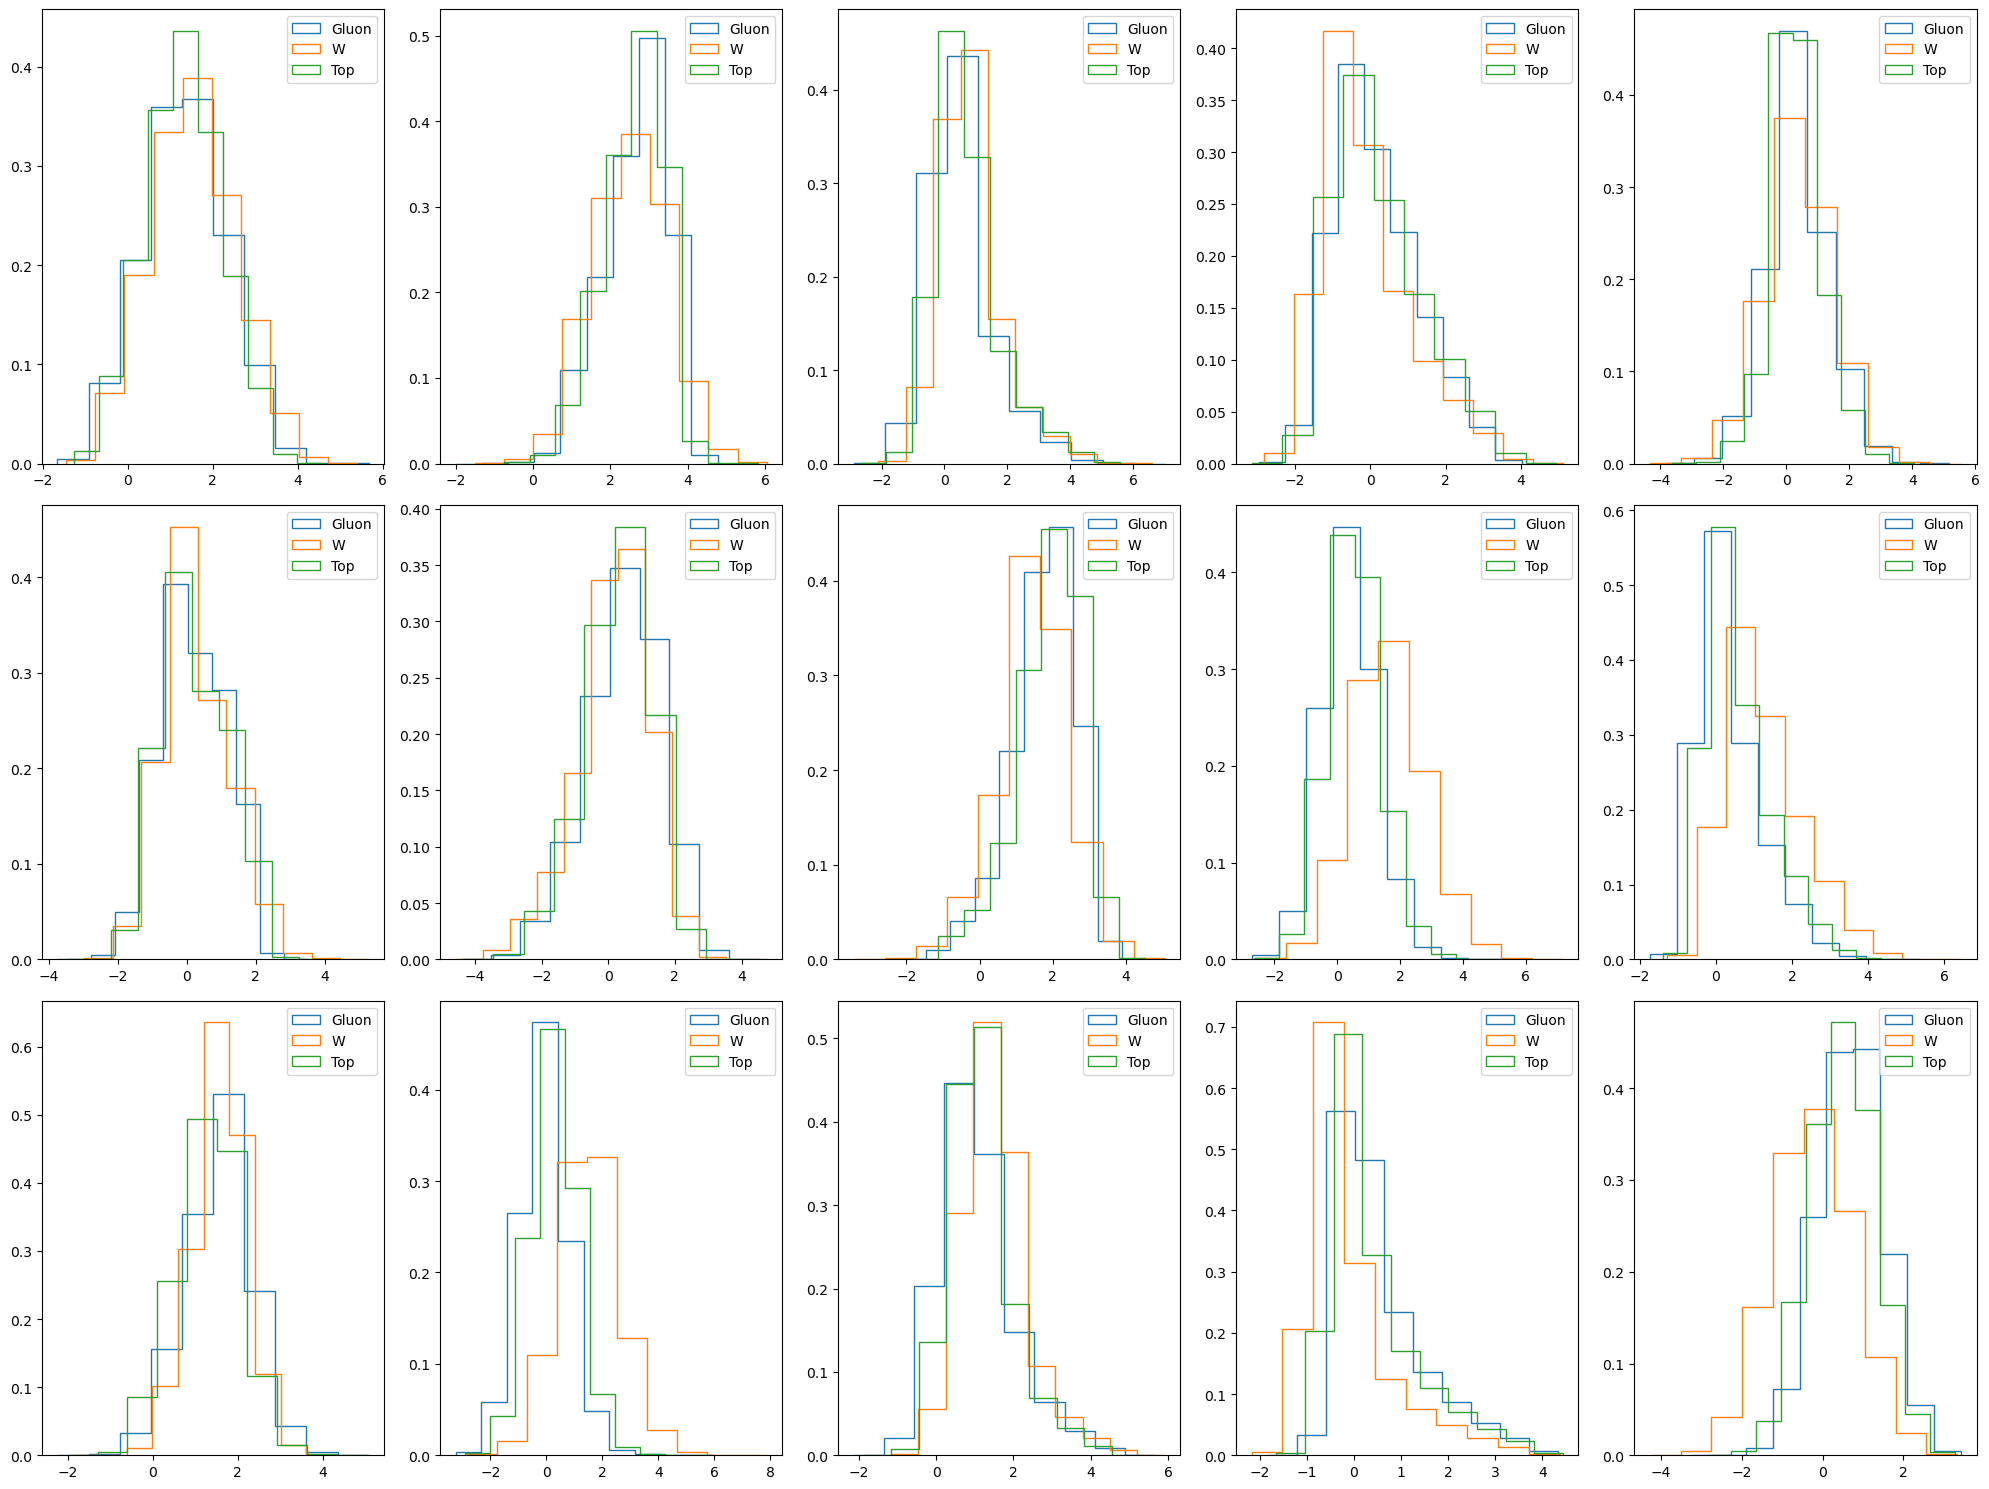

In [18]:
fig, ax = plt.subplots(3, 5, figsize=(20,15), tight_layout=True)
ax = ax.flatten()
plot_lbl = [0, 2, 4]

for i in range(latent_dim):
    for j in plot_lbl:
        ax[i].hist(latent_jets[labels[:,j]==1, i], label=labels_str[j], histtype='step', density=True)
    ax[i].legend()
plt.show()

In [68]:
fig.savefig('15ld_gwt.pdf')

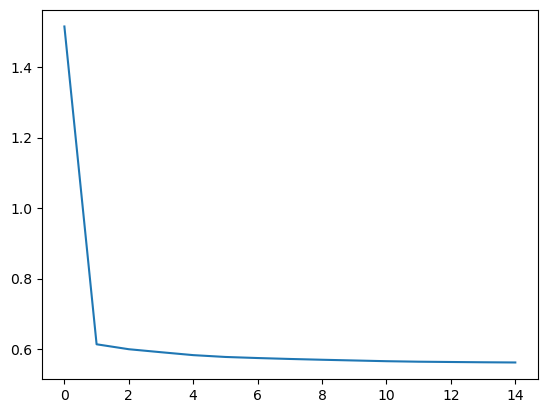

In [19]:
loss = np.load('models/trainloss_history'+ model_name +'.npy')
plt.plot(np.arange(len(loss)), loss)
plt.show()

## T_SNE

In [20]:
test_dataloader = GraphDataLoader(test_dataset, shuffle=True, batch_size=1)

In [21]:
latent_jets = []
labels = []
for batch in tqdm(test_dataloader):
    encoder.eval()
    labels.append(batch.ndata['labels'][0])
    batch = batch.to('cuda')
    with torch.no_grad():
        latent_jet = encoder(batch).detach().cpu()
        latent_jets.append(torch.mean(latent_jet, dim = 0))


latent_jets = torch.stack(latent_jets)
labels = torch.stack(labels)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [36]:
def tsne(latent_jets, labels, target_lbl, ndata=1000, perplexity=20, n_components=2):
    mask = sum([labels.nonzero().squeeze()[:,1] == val for val in target_lbl]).bool()
    X = latent_jets[mask][:ndata]
    lbl = labels[mask][:ndata].nonzero().squeeze()[:,1]
    X_emb = TSNE(n_components=n_components, perplexity=perplexity, n_iter=2000, verbose=True).fit_transform(X)

    return X_emb, lbl

In [23]:
def plot_tsne(X_emb, lbl_emb, plot_lbl, fig):

    labels_str = ['Gluon', 'Quark', 'W', 'Z', 'Top', 'Undefined']
    n = X_emb.shape[1]
    if n == 2:
        ax = fig.add_subplot(111)

        for j in plot_lbl:
            X_plt = X_emb[lbl_emb==j]
            ax.scatter(X_plt[:,0], X_plt[:,1], label=labels_str[j], s = 8)
        
    elif n == 3:
        ax = fig.add_subplot(111, projection='3d')

        for j in plot_lbl:
            X_plt = X_emb[lbl_emb==j]
            ax.scatter(X_plt[:,0], X_plt[:,1], X_plt[:,2], label=labels_str[j], s = 8)

    else:
        print('mannaggia')
        return None
    
    return ax

### 2D

In [143]:
X_emb, lbls = tsne(latent_jets, labels, [0, 2, 4], 2000, perplexity=28)
print(X_emb.shape, lbls.shape)

using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/2000 [00:00<?, ?it/s]

fitting...


  0%|          | 0/2000 [00:00<?, ?it/s]

(2000, 2) torch.Size([2000])


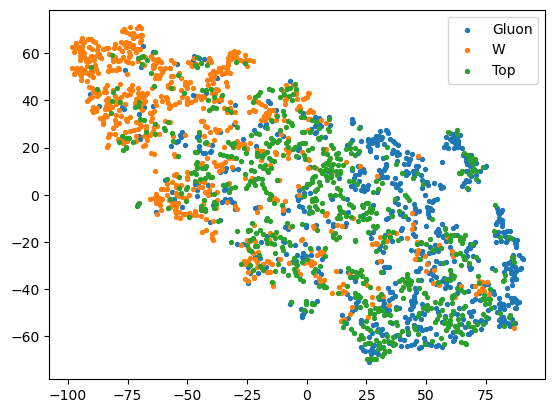

In [144]:
fig2d = plt.figure()
ax = plot_tsne(X_emb, lbls, [0, 2, 4], fig2d)
ax.legend()
plt.show()

In [84]:
fig2d.savefig('models/tsne'+model_name+'.pdf')

In [ ]:
17, 28, 25, 35, 38, 32, 26, 27, 20, 16

### 3D

In [110]:
X_emb, lbl_emb = tsne(latent_jets, labels, [0, 2], 2000, n_components=3)

using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/2000 [00:00<?, ?it/s]

fitting...


  0%|          | 0/2000 [00:00<?, ?it/s]

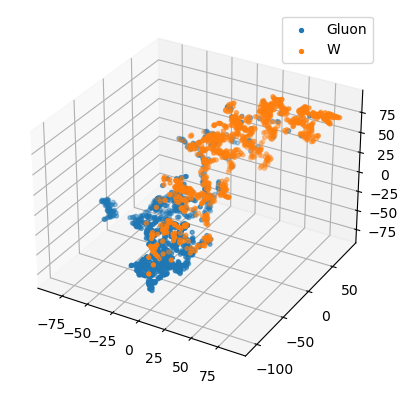

In [117]:

fig3d = plt.figure()
ax = plot_tsne(X_emb, lbl_emb, [0, 2], fig3d)
ax.legend()
plt.show()

In [90]:
fig.savefig('tsne_10_latent_dim_wt.pdf')

## K-Means + accuracy

In [114]:
def kmeans_acc(cluster_ids, lbls):
    correct = 0
    for i in range(cluster_ids.max()+1):
        counts = lbls[cluster_ids==i].bincount()
        correct += counts.max()

    return correct/lbls.shape[0]

In [145]:
c_ids_torch, c_c_torch = kmeans(torch.tensor(X_emb), num_clusters=3, distance='euclidean', device='cuda')

c_ids_skl = KMeans(3, max_iter=1000, tol=1e-4).fit_predict(X_emb)

running k-means on cuda..


[running kmeans]: 21it [00:00, 669.34it/s, center_shift=0.000000, iteration=21, tol=0.000100] 


In [146]:
accuracy_torch = kmeans_acc(c_ids_torch, lbls)
accuracy_skl   = kmeans_acc(c_ids_skl, lbls)
print(f'Accuracy w/ kmeans-torch: {accuracy_torch:.2%}', 
      f'\nAccuracy w/ scikit-learn: {accuracy_skl:.2%}')

Accuracy w/ kmeans-torch: 57.25% 
Accuracy w/ scikit-learn: 57.25%
